<center><h1>Question 1: Gaussian Mixture Models</h1></center>

<h3>Objectives:</h3>
<code>
    <li>Construct a GMM by implementing the EM algorithm, on all the images in the dataset.</li>
    <li>Experiment with 3 different numbers of mixtures.</li>
    <li>Plot the likelihood curve as the EM iteration progresses.</li>
    <li>Post training, Generate and plot 100 images in a grid of 10 by 10 with all three GMMs separately and record your observations.</li>
    <li>Perform posterior inference with all three GMMs, compute and report Normalized Mutual Information (NMI).</li>
</code>

#### 1. Import Libraries

In [ ]:
import os
import zipfile
import numpy as np
from natsort import natsorted
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import torchvision

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#### 2. Build Transform for picture preprocessing.

<ol>
    <li>Resize images from 512x512 to <b>16x16.</b></li>
    <li>Convert these images to tensors.</li>
</ol>

In [ ]:
transform = transforms.Compose([
                    transforms.Resize(size = (16,16)),
                    transforms.ToTensor(),
                    ])
train_data = torchvision.datasets.ImageFolder(root='./../data/afhq/train/', transform=transform)

#### 3. Preparation of data loader and construction of data tensor to be passed to the GMM model.

In [ ]:
train_loader = DataLoader(train_data, batch_size=32,shuffle=True)
data = []
for images,_ in tqdm(train_loader):
    flattened_images = images.view(images.size(0), -1)  # Flatten each image
    data.append(flattened_images)
data = torch.cat(data, dim=0)

100%|███████████████████████████████████████████████████████████████████████████| 458/458 [00:34<00:00, 13.28it/s]


#### 4. Defining Gaussian Mixture Class for initializing means and variances, and running the EM algorithm on our data.

In [80]:
class GaussianMixture:
    def __init__(self, n_components, n_iters = 50, eps = 1e-5):
        self.n_components = n_components
        self.n_iters = n_iters
        self.device = "cpu" 
        self.eps = eps
        self.means = None
        self.covariances = None
        self.mixture_coeff = None
        self.likelihoods = []

    def _init_params(self, data):
        num_samples, num_features = data.shape
        self.means = data[torch.randint(0, num_samples, (self.n_components,))].to(self.device)
        while True:
            self.covariances = torch.stack([torch.eye(num_features) for _ in range(self.n_components)]).to(self.device)
            if torch.eq(torch.sum(self.covariances != self.covariances), torch.tensor(0.0)):
                break
        self.mixture_coeff = (torch.ones(self.n_components) / self.n_components).to(self.device)
    
    def _plot_likelihood_curve(self):
        plt.plot(range(len(self.likelihoods)), self.likelihoods)
        plt.xlabel("Iteration No.")
        plt.ylabel("Log Likelihood of iteration")
        plt.title("Iteration v/s Log Likelihood")
        plt.show()

    def fit(self, x):
        self._init_params(x)
        #print("Params ready!!!!")
        for iteration in tqdm(range(self.n_iters)):
            resp = self._e_step(x)
            self._m_step(x, resp)
            for i in range(self.n_components):
                self.covariances[i].add_(torch.eye(self.covariances[i].size(0)) * self.eps)
            log_likelihood = self._compute_likelihood(x)
            self.likelihoods.append(log_likelihood.item())
            if iteration > 0:
                if abs(self.likelihoods[-1] - self.likelihoods[-2]) < self.eps:
                    break

    def predict(self, x, probs=False):
        """
        Assigns input data to one of the mixture components by evaluating the likelihood under each.
        If probs=True returns normalized probabilities of class membership.
        args:
            x:          torch.Tensor (n, d) or (n, 1, d)
            probs:      bool
        returns:
            p_k:        torch.Tensor (n, k)
            (or)
            y:          torch.LongTensor (n)
        """
        x = self.check_size(x)

        weighted_log_prob = self._estimate_log_prob(x) + torch.log(self.pi)

        if probs:
            p_k = torch.exp(weighted_log_prob)
            return torch.squeeze(p_k / (p_k.sum(1, keepdim=True)))
        else:
            return torch.squeeze(torch.max(weighted_log_prob, 1)[1].type(torch.LongTensor))


    def predict_proba(self, x):
        """
        Returns normalized probabilities of class membership.
        args:
            x:          torch.Tensor (n, d) or (n, 1, d)
        returns:
            y:          torch.LongTensor (n)
        """
        return self.predict(x, probs=True)


    def sample(self, n):
        """
        Samples from the model.
        args:
            n:          int
        returns:
            x:          torch.Tensor (n, d)
            y:          torch.Tensor (n)
        """
        counts = torch.distributions.multinomial.Multinomial(total_count=n, probs=self.pi.squeeze()).sample()
        x = torch.empty(0, device=counts.device)
        y = torch.cat([torch.full([int(sample)], j, device=counts.device) for j, sample in enumerate(counts)])

        # Only iterate over components with non-zero counts
        for k in np.arange(self.n_components)[counts > 0]: 
            if self.covariance_type == "diag":
                x_k = self.mu[0, k] + torch.randn(int(counts[k]), self.n_features, device=x.device) * torch.sqrt(self.var[0, k])
            elif self.covariance_type == "full":
                d_k = torch.distributions.multinomial.MultivariateNormal(self.mu[k], self.var[0,k])
                x_k = torch.stack([d_k.sample() for _ in range(int(counts[k]))])

            x = torch.cat((x, x_k), dim=0)

        return x, y

    def _compute_likelihood(self, data):

        likelihoods = torch.zeros(data.shape[0], self.n_components).to(self.device)

        for i in range(self.n_components):

            prob_dist = torch.distributions.multivariate_normal.MultivariateNormal(self.means[i], self.covariances[i])

            likelihoods[:, i] = self.mixture_coeff[i] * prob_dist.log_prob(data)

        return likelihoods.sum(dim=1).mean()

    def _calculate_log_det(self, var):
        """
        Calculate log determinant in log space, to prevent overflow errors.
        args:
            var:            torch.Tensor (1, k, d, d)
        """
        log_det = torch.empty(size=(self.n_components,)).to(var.device)
        
        for i in range(self.n_components):
            log_det[i] = 2 * torch.log(torch.diagonal(torch.linalg.cholesky(var[0,i]))).sum()

        return log_det.unsqueeze(-1)


    def _e_step(self, data):

        resp = torch.zeros(data.shape[0], self.n_components).to(self.device)

        for i in range(self.n_components):

            prob_dist = torch.distributions.multivariate_normal.MultivariateNormal(self.means[i], self.covariances[i])

            resp[:, i] = self.mixture_coeff[i] * prob_dist.log_prob(data)

        m = torch.nn.Softmax(dim=1)
        return m(resp)

 

    def _m_step(self, data, resp):
        self.mixture_coeff = resp.mean(dim=0)
        weighted_data = data.unsqueeze(1) * resp.unsqueeze(2)
        self.means = weighted_data.sum(dim=0) / resp.sum(dim=0).unsqueeze(1)
        for i in range(self.n_components):
            centered_data = data - self.means[i]
            self.covariances[i] = torch.matmul(centered_data.t(), centered_data * resp[:, i].unsqueeze(1)) / resp[:, i].sum()
            self.covariances[i] += 1e-6 * torch.eye(data.shape[1])


    def _generate_samples(self, num_samples=100):
        n_components, n_features = self.means.shape
        gen_samples = torch.zeros(num_samples, n_features)
        for _ in range(num_samples):
            component = torch.randint(0, n_components, (1,))
            prob_dist = torch.distributions.multivariate_normal.MultivariateNormal(self.means[component], self.covariances[component])
            sample = prob_dist.sample()
            gen_samples[_] = sample
        return gen_samples

    def _visualize_samples(self, n_samples=100):
        generated_samples = self._generate_samples(n_samples)
        grid_size = (10, 10)
        _, axarr = plt.subplots(*grid_size, figsize=(10, 10))
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                sample = generated_samples[i * grid_size[1] + j].view(3, 16, 16).permute(1,2,0).numpy()
                sample = np.clip(sample, 0, 1)
                axarr[i, j].imshow(sample)
                axarr[i, j].axis('off') #remove x, y axis from images
        plt.suptitle(f"Samples generated for ({self.n_components} Components)")
        plt.show()

    
    def _calc_entropy(self, labels):
        _, label_counts = torch.unique(labels, return_counts=True)
        prob = label_counts.float() / len(labels)
        entropy_value = -torch.sum(prob * torch.log2(prob))
        return entropy_value

 

    def _calc_mi(self, density_cluster_assignments, class_labels):
        class_labels = class_labels.float()
        density_cluster_assignments = density_cluster_assignments.float()
        max_bins = int((class_labels.max() + 1) * (density_cluster_assignments.max() + 1))
        joint_distribution = torch.histc(
            class_labels * (density_cluster_assignments.max() + 1) + density_cluster_assignments,
            bins=max_bins,
            min=0,
            max=max_bins
        )
        joint_distribution = joint_distribution.view(int(class_labels.max() + 1), int(density_cluster_assignments.max() + 1))
        class_prob = joint_distribution.sum(dim=1) / len(class_labels)
        prob_of_cluster = joint_distribution.sum(dim=0) / len(class_labels)
        joint_prob = joint_distribution / len(class_labels)
        mutual_info = torch.sum(joint_prob * torch.log2(joint_prob / (torch.outer(class_prob, prob_of_cluster) + self.eps) + self.eps))
        return mutual_info

    def _calc_nmi(self, cluster_assignments, class_labels):
        mutual_information = self._calc_mi(cluster_assignments, class_labels)
        entropy_cluster = self._calc_entropy(cluster_assignments)
        entropy_class = self._calc_entropy(class_labels)
        denom = entropy_class + entropy_cluster
        nmi = 2 * mutual_information / denom
        return nmi

#### 5. Experiment with different number of mixture densities. 

<p>In this experiment, mixture densities in the range of [2, 10] have been taken and the samples have been generated.</p>
<p>For each mixture density, likelihood graph has been plotted and then 100 samples have been generated.</p>

GMM Experiment with 2 components


  5%|███▉                                                                          | 2/40 [00:00<00:11,  3.27it/s]


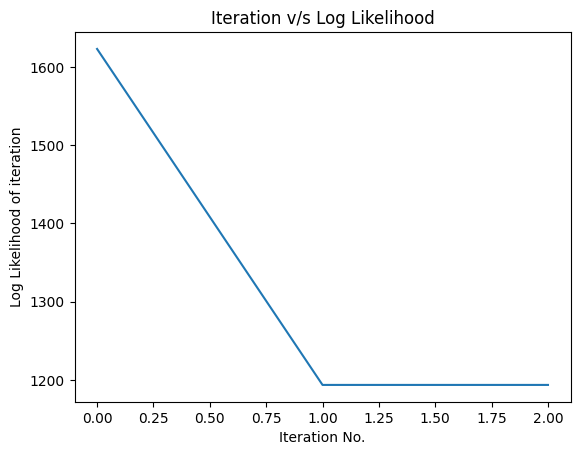

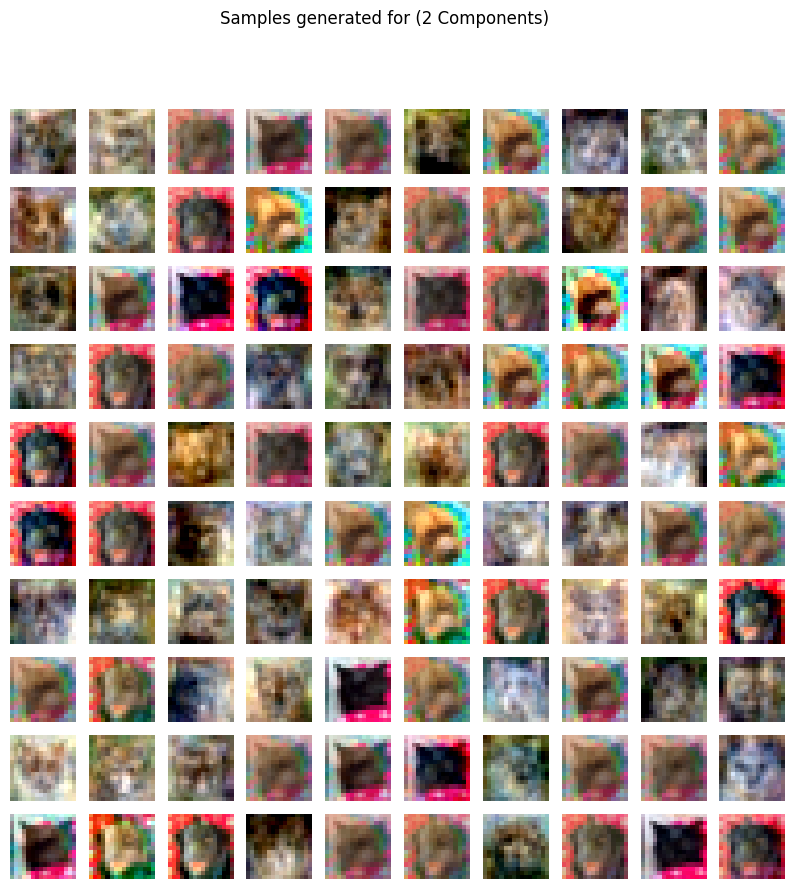

Normalized Mutual Information for 2 components: tensor(0.0003)
GMM Experiment with 3 components


 10%|███████▊                                                                      | 4/40 [00:01<00:13,  2.69it/s]


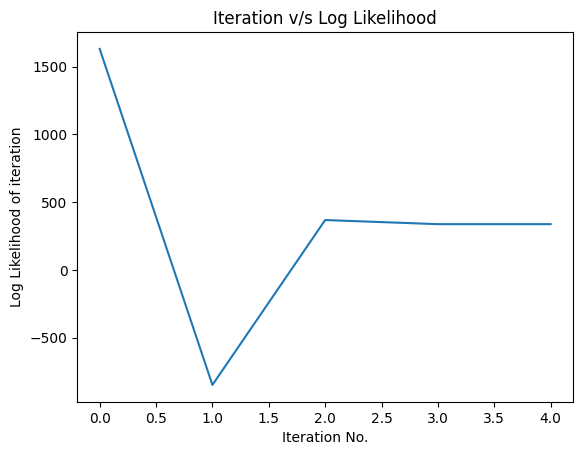

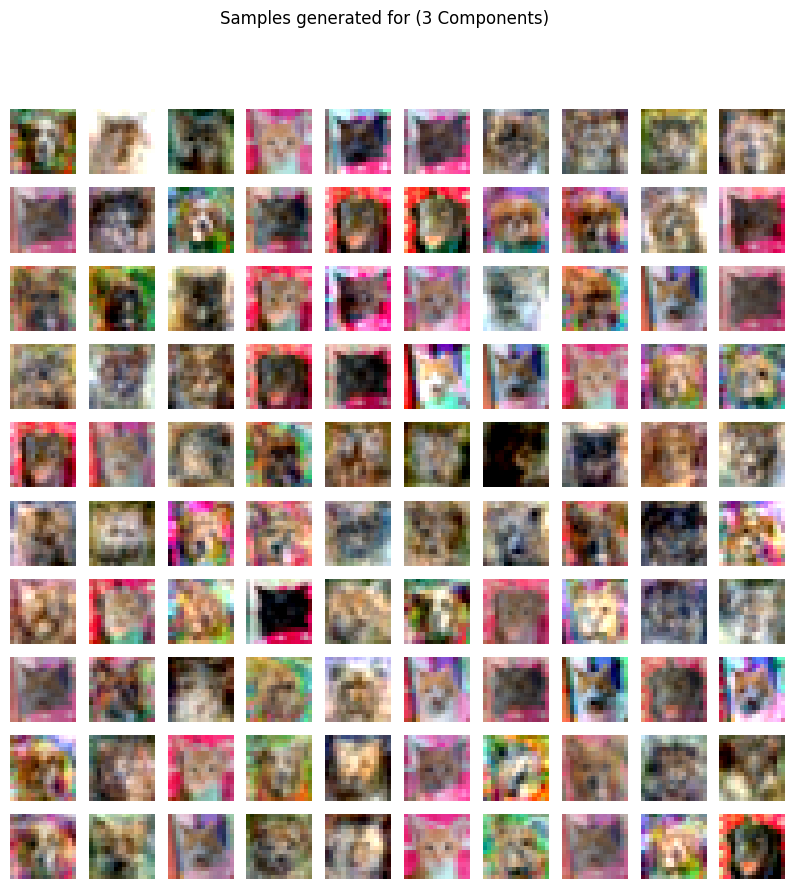

Normalized Mutual Information for 3 components: tensor(0.0005)
GMM Experiment with 4 components


 12%|█████████▊                                                                    | 5/40 [00:02<00:17,  2.05it/s]


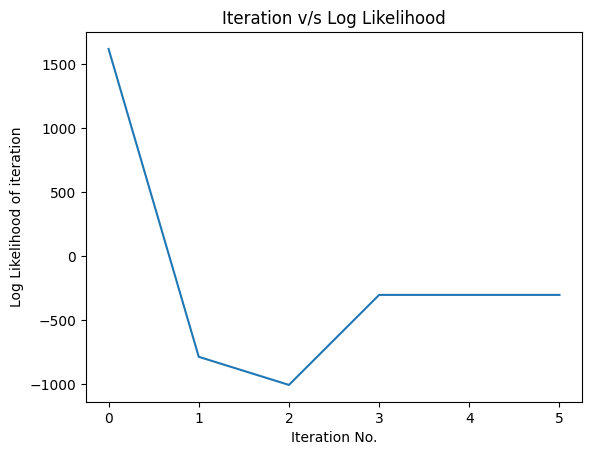

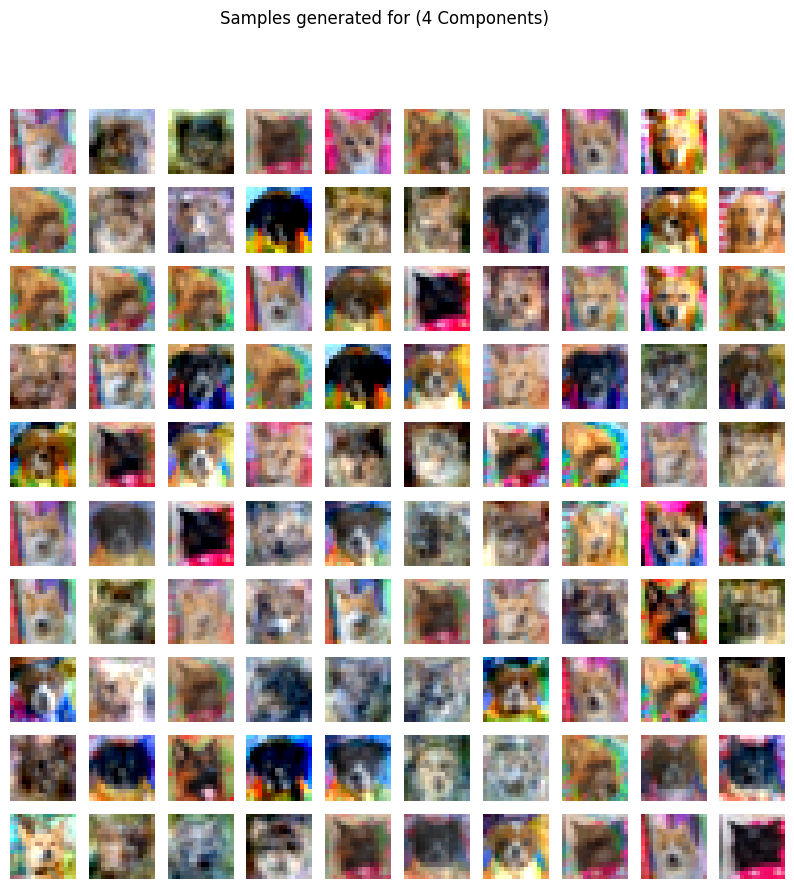

Normalized Mutual Information for 4 components: tensor(0.0003)
GMM Experiment with 5 components


100%|█████████████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.62it/s]


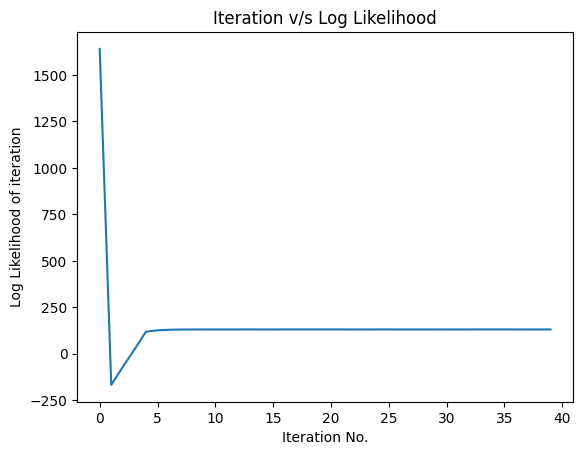

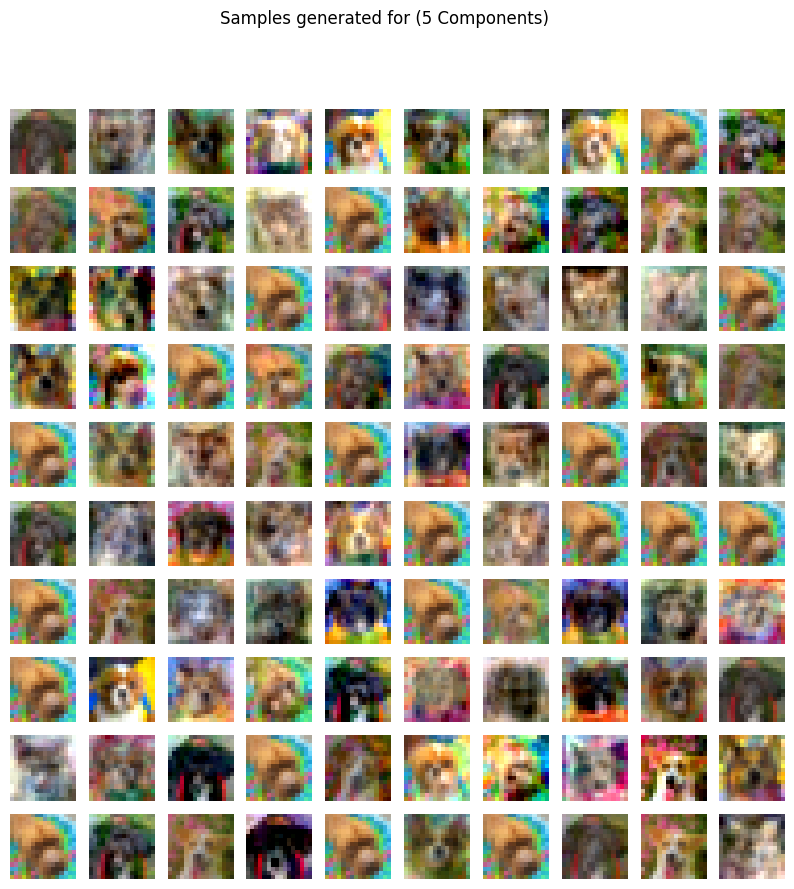

Normalized Mutual Information for 5 components: tensor(2.9571e-05)
GMM Experiment with 6 components


100%|█████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.70it/s]


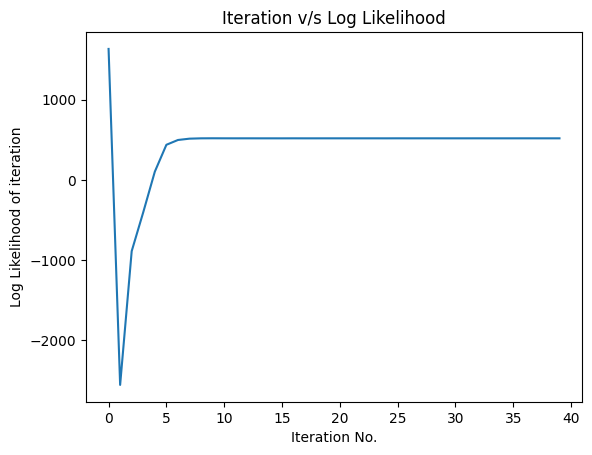

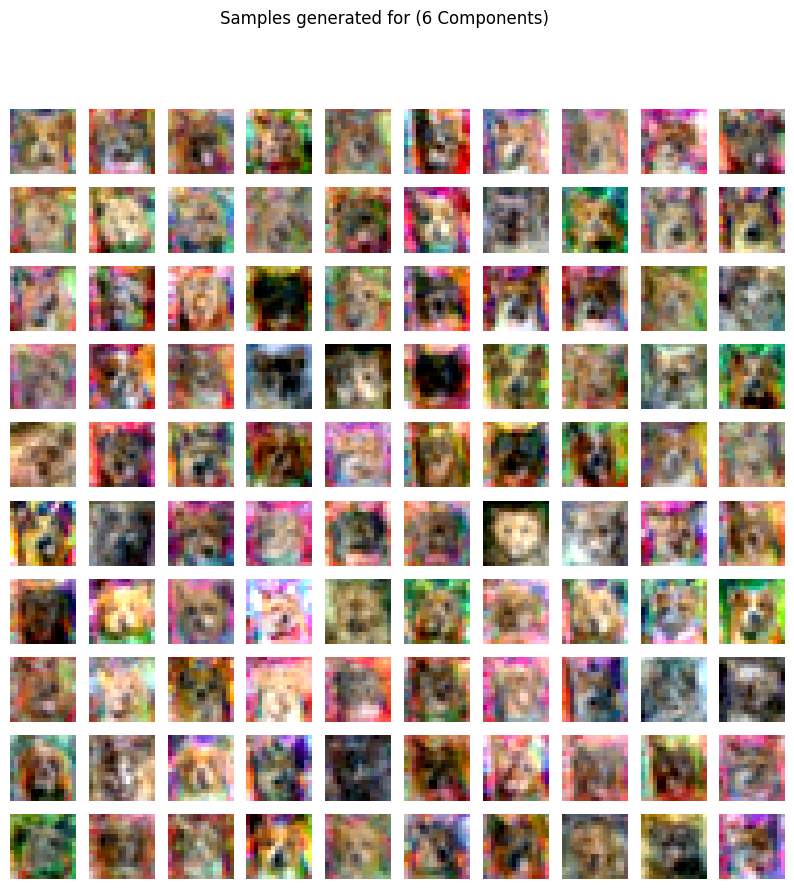

Normalized Mutual Information for 6 components: tensor(-3.1918e-05)
GMM Experiment with 7 components


 50%|██████████████████████████████████████▌                                      | 20/40 [00:14<00:14,  1.36it/s]


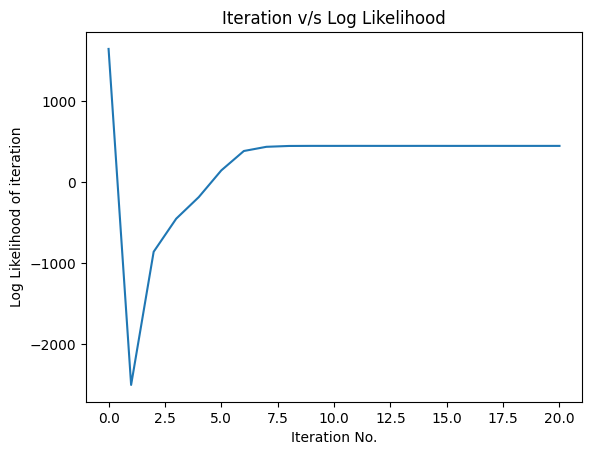

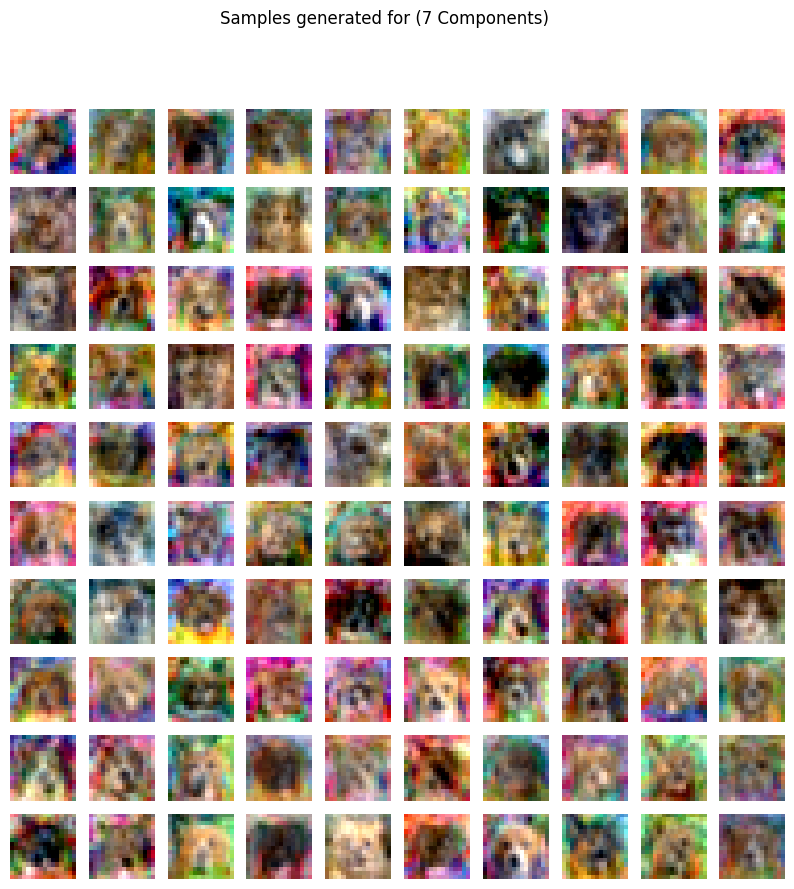

Normalized Mutual Information for 7 components: tensor(-8.5039e-05)
GMM Experiment with 8 components


100%|█████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


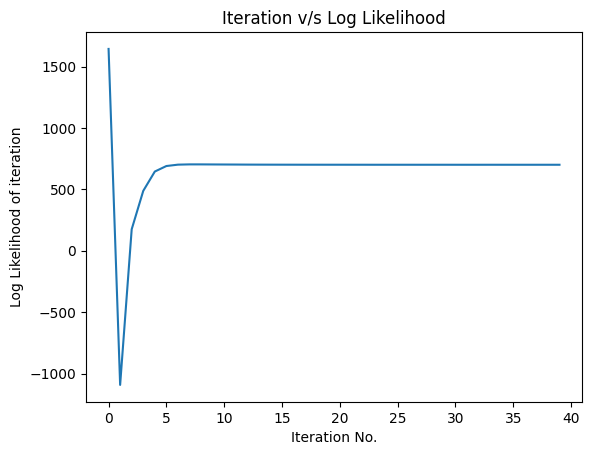

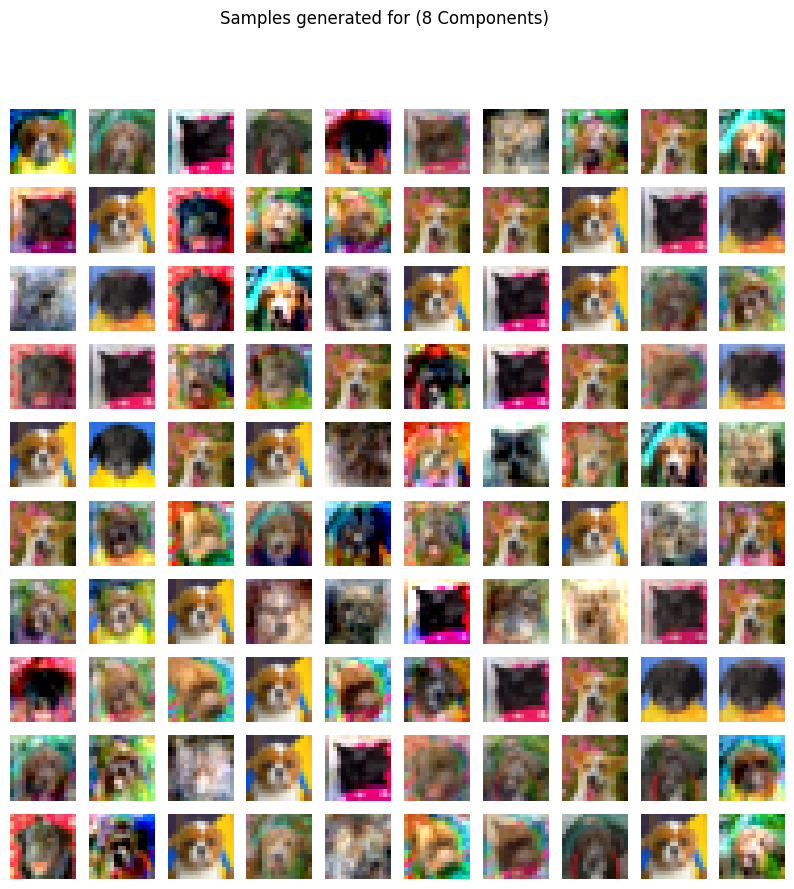

Normalized Mutual Information for 8 components: tensor(0.0001)
GMM Experiment with 9 components


100%|█████████████████████████████████████████████████████████████████████████████| 40/40 [00:36<00:00,  1.09it/s]


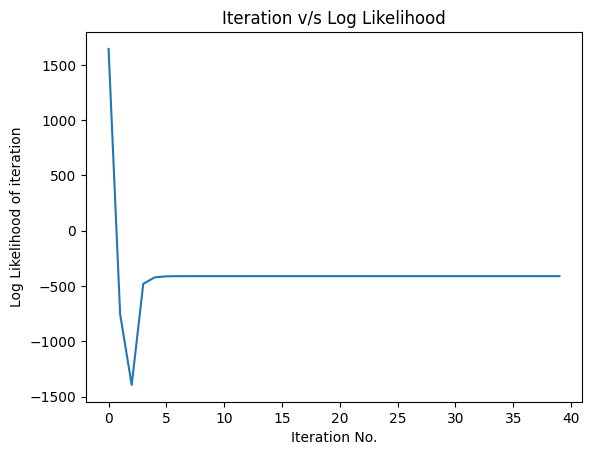

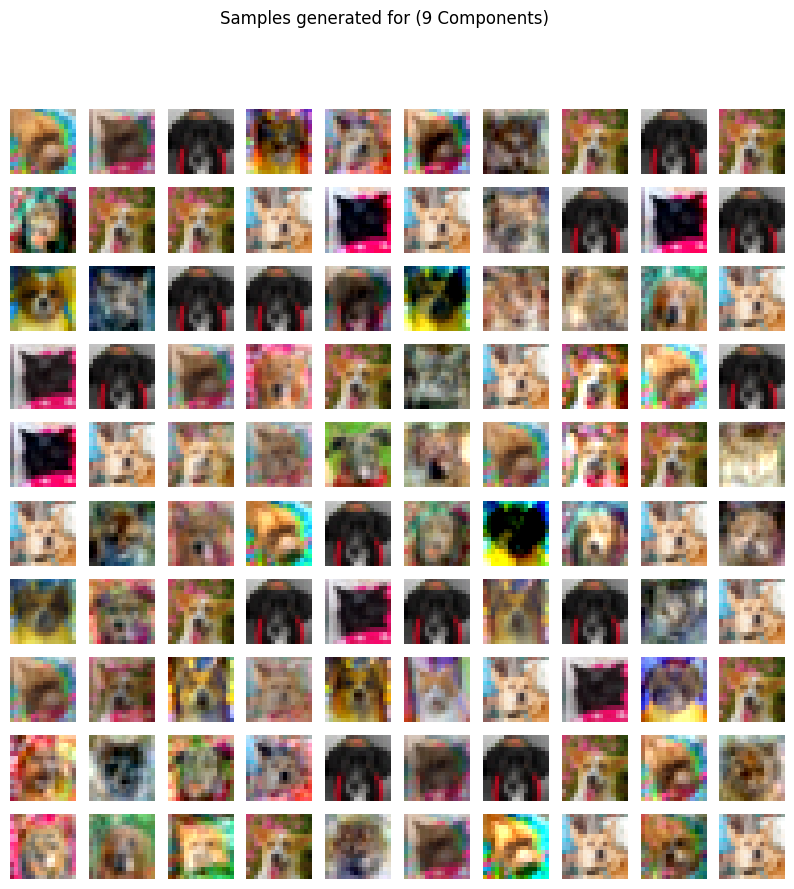

Normalized Mutual Information for 9 components: tensor(-0.0001)
GMM Experiment with 10 components


100%|█████████████████████████████████████████████████████████████████████████████| 40/40 [00:39<00:00,  1.01it/s]


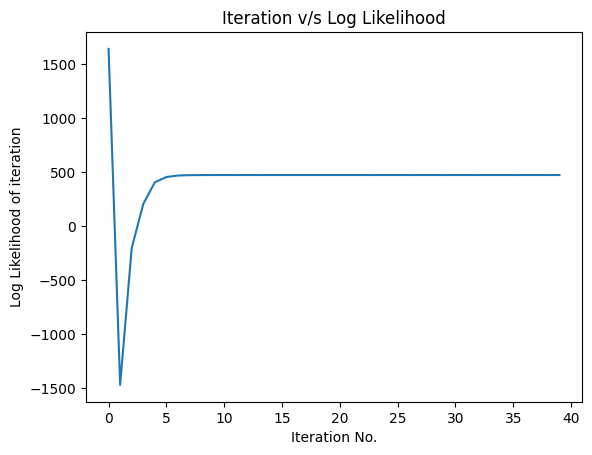

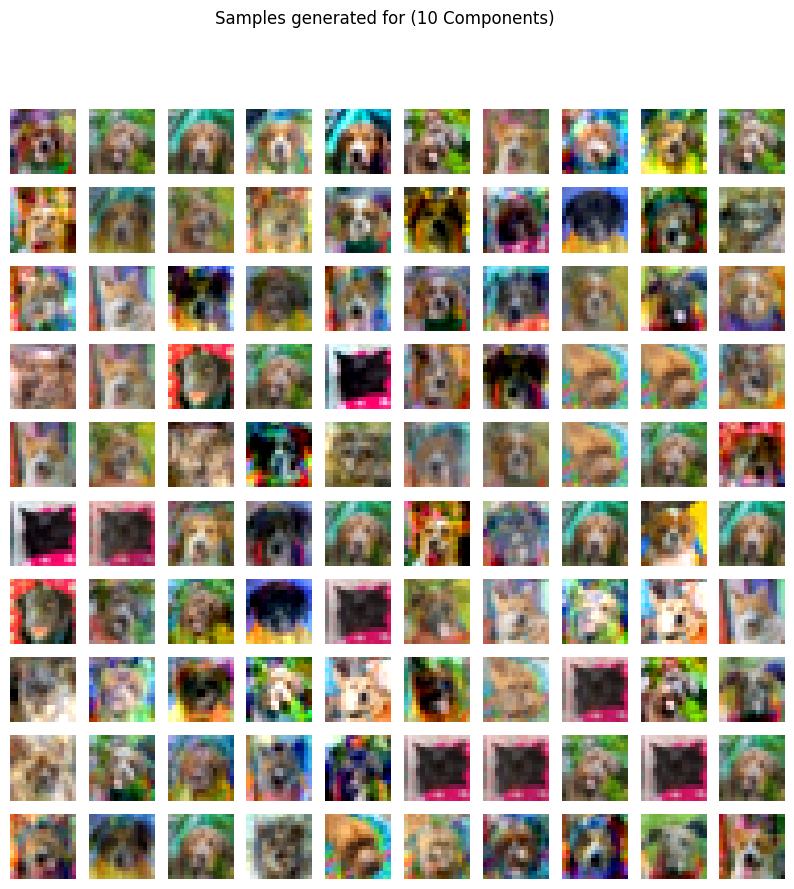

Normalized Mutual Information for 10 components: tensor(-7.7275e-05)


In [ ]:
mixture_densities = [2, 3, 4, 5, 6, 7, 8, 9, 10]
nmi_scores = []
for num_component in mixture_densities:
    print("GMM Experiment with " + str(num_component) + " components")
    gmm = GaussianMixture(n_components=num_component, n_iters = 40, eps = 1e-5)
    gmm.fit(data)
    gmm._plot_likelihood_curve()
    gmm._visualize_samples(100)
    cluster_assignments = gmm._e_step(data).argmax(dim=1).cpu()
    true_labels = torch.tensor(train_data.targets)
    nmi_score = gmm._calc_nmi(cluster_assignments, true_labels)
    nmi_scores.append(nmi_score)
    print("Normalized Mutual Information for " + str(num_component) + " components: " + str(nmi_score))

Text(0.5, 1.0, 'NMI Score for different GMM densities')

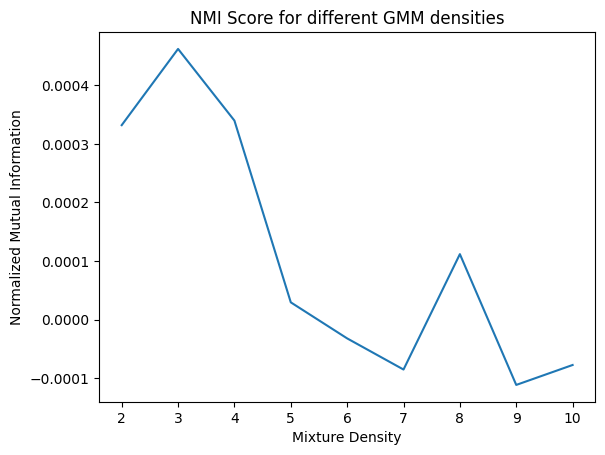

In [ ]:
plt.plot(mixture_densities, nmi_scores)
plt.xlabel("Mixture Density")
plt.ylabel("Normalized Mutual Information")
plt.title("NMI Score for different GMM densities")

# Observations
<hr>

### Reconstruction quality

<ol>
    <li>We notice that the quality of samples from <b>GMM improves as we move from 2 mixture densities to 6 densities and then gradually decreases till 10 mixture densities.</b></li>
    <li>NMI score for different mixture densities roughly follows a similar pattern, with <b>highest NMI at 4, or 5, or 6 mixture densities.</b></li>
</ol>

# Possible reasons for the above observations
<hr>

<p>We <b>hypothesize</b> that the different animal faces come from a probability distribution having two modes, so the dataset might have about <b>4-6 modes</b> in total. Hence, 4-6 mixture densities gives us the best result for three classes. Mixture densities less than 4-6 cannot capture enough information between them, while using mixture densities more than that distributes the likelihood between different(extra) densities hence leading to drop in reconstruction. </p>

<hr>
<hr>
<hr>

<center><h1>Question 2: Vanilla VAE</h1></center>

<h3>Objectives:</h3>
<code>
    <li>Implement a vanilla VAE with MSE for conditional likeli- hood. Experiment with a single and multiple sample of z during training that goes at the input to the decoder.</li>
    <li>Plot 10 by 10 grids of both recon- structions and generations. Plot the loss curves for likelihood, KL, and the combined terms.</li>
    <li>Build a CNN-based classifier for 3 classes using the images in the training part of the dataset and report the accuracy on the validation part.</li>
    <li>Now, using the VAE trained, perform a posterior infer- ence on all the images and use the thus obtained latent vectors with an MLP for classification.</li>
</code>

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import zipfile
# from natsort import natsorted
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
# from model import VAE

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics

%reload_ext autoreload
%autoreload 2

In [4]:
# Load dataset
device = torch.device("cuda")
cpu_device = torch.device("cpu")

In [8]:
DATA_DIR_PATH = "autoencoders/dataset"
DATA_PATH = os.path.join(DATA_DIR_PATH, 'animal-faces')
DATA_URL = 'https://www.kaggle.com/datasets/andrewmvd/animal-faces/download?datasetVersionNumber=1'
device = torch.device("cuda")
cpu_device = torch.device("cpu")

class AnimalfaceDataset(Dataset):
    def __init__(self, transform, type='train', label_dict = {"dog":0, "cat":1, "wild":2} , img_width=128) -> None:
        self.transform = transform
        # self.root_dir specifies weather you are at afhq/train or afhq/val directory
        self.label_dict = label_dict
        self.root_dir = os.path.join(DATA_PATH, type)
        assert os.path.exists(self.root_dir), "Check for the dataset, it is not where it should be. If not present, you can download it by clicking above DATA_URL"
        subdir = os.listdir(self.root_dir)
        self.image_names = []
        
        for category in subdir:
            subdir_path = os.path.join(self.root_dir, category)
            self.image_names+=os.listdir(subdir_path)

        self.img_arr = torch.zeros((len(self.image_names), 3, img_width ,img_width))
        self.labels = torch.zeros(len(self.image_names))
            
        for i,img_name in enumerate(tqdm(self.image_names)):
            label = self.label_dict[img_name.split("_")[1]]
            img_path = os.path.join(self.root_dir, img_name.split("_")[1], img_name)
            # Load image and convert it to RGB
            img = Image.open(img_path).convert('RGB')
            # Apply transformations to the image
            img = self.transform(img)
            self.img_arr[i] = img
            self.labels[i] = label
            
    def __getitem__(self, idx):
        return self.img_arr[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.image_names)

In [9]:
width = 128
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((width,width))])

In [10]:
train_data = AnimalfaceDataset(transform=train_transform, img_width=width)

  0%|          | 0/14630 [00:00<?, ?it/s]/data/home/vasumehra/miniconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 14630/14630 [02:22<00:00, 102.51it/s]


In [33]:
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((width,width))])
val_data = AnimalfaceDataset(transform=val_transform, type="val", img_width=width)

  0%|          | 0/1500 [00:00<?, ?it/s]/data/home/vasumehra/miniconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1500/1500 [00:07<00:00, 211.55it/s]


In [12]:
def show_img(x):
    plt.figure(figsize=(2,2))
    plt.imshow(x.permute(0,2,3,1).detach().to(cpu_device).numpy()[0])

torch.Size([512, 3, 128, 128]) torch.Size([512])


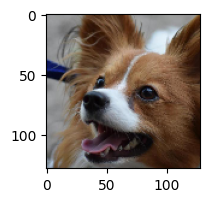

In [13]:
BATCH_SIZE = 512
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
x, y = next(iter(val_loader))
print(x.shape, y.shape)
show_img(x)

# Q2 - Vanilla - VAE

In [14]:
class Encoder_vae(nn.Module):
    def __init__(self, filters,  kernel_sizes,  strides, hiddens_sizes, paddings, 
                 return_only_conv=False, return_only_liner=False, droput_prob=0.1, curr_device="cuda", n_samples=5):
        super(Encoder_vae, self).__init__()
        
        self.curr_device = curr_device
        self.return_only_conv = return_only_conv
        self.return_only_liner = return_only_liner
        self.n_samples = n_samples
        conv_layers = []
        for i in range(len(kernel_sizes)):
            conv_layers.append(nn.Conv2d(filters[i], filters[i+1], kernel_sizes[i], strides[i], paddings[i]))
            conv_layers.append(nn.ReLU(True))

        self.conv_layer = nn.Sequential(*conv_layers)

        hidden_layers = []
        hiddens_sizes_cpy = hiddens_sizes.copy()
        hiddens_sizes_cpy[-1] = hiddens_sizes_cpy[-1]*2 # mu and sigma
        for i in range(len(hiddens_sizes_cpy)-1):
            hidden_layers.append(nn.Dropout(p=droput_prob))
            hidden_layers.append(nn.Linear(hiddens_sizes_cpy[i], hiddens_sizes_cpy[i+1]))
            if i < len(hiddens_sizes_cpy)-2:
                hidden_layers.append(nn.ReLU(True))
        self.liner_layer = nn.Sequential(*hidden_layers)
       
    def forward(self, x):
        if self.return_only_conv:
            x = self.conv_layer(x)
            x = x.flatten(start_dim=1)
            z = x
        elif self.return_only_liner:
            x = x.flatten(start_dim=1)
            x = self.liner_layer(x)
            z = x
        else:
            x = self.conv_layer(x)
            x = x.flatten(start_dim=1)
            x = self.liner_layer(x)
            z = x

        z_dim = z.shape[-1]//2
        mu, log_var = z[:, :z_dim], z[:, z_dim:]
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn((z_dim, self.n_samples)).to(torch.device(self.curr_device))
        z = []
        for i in range(self.n_samples):
            z.append(mu + sigma*eps[:,i])
        z = torch.stack(z)
        return z, mu, log_var

    
class Decoder(nn.Module):
    def __init__(self, conv_op_size,  filters, kernel_sizes, strides, output_paddings, 
                   paddings, hiddens_sizes, return_only_conv=False, return_only_liner=False, droput_prob=0.1):
        super(Decoder, self).__init__()
        self.return_only_conv = return_only_conv
        self.return_only_liner = return_only_liner
        print(hiddens_sizes)
        
        hidden_layers = []
        for i in range(len(hiddens_sizes)-1):
            hidden_layers.append(nn.Dropout(p=droput_prob))
            hidden_layers.append(nn.Linear(hiddens_sizes[i], hiddens_sizes[i+1]))
            if i < len(hiddens_sizes)-2:
                hidden_layers.append(nn.ReLU(True))
        
        self.liner_layer = nn.Sequential(*hidden_layers)

        conv_layers = []
        for i in range(len(kernel_sizes)):
            conv_layers.append(nn.ConvTranspose2d(filters[i], filters[i+1], kernel_sizes[i], 
                                                  stride=strides[i], output_padding=output_paddings[i], padding=paddings[i]))
            if i < len(kernel_sizes)-1:
                conv_layers.append(nn.ReLU(True))

        self.conv_layer = nn.Sequential(*conv_layers)        
        self.unflatten = nn.Unflatten(dim=2, unflattened_size=conv_op_size)
        
        
    def forward(self, x):
        if self.return_only_conv:
            x = self.unflatten(x)
            x = self.conv_layer(x)
            x = torch.sigmoid(x)
            return x
        elif self.return_only_liner:
            # print(x.shape)
            x = self.liner_layer(x)
            x = self.unflatten(x)
            x = torch.sigmoid(x)
            return x
        else:
            x = self.liner_layer(x)
            x = self.unflatten(x)
            ans = []
            for each in x:
                ans.append(self.conv_layer(each))
            x_hat = torch.stack(ans)
            x_hat = torch.sigmoid(x_hat)
        return x_hat


class VAE(nn.Module):
    def __init__(self, feature_size=2048, conv_ip_size=(32, 14, 14), filters = [3,12,24,48,128],  
                 kernel_sizes = [3, 3, 3, 3], strides = [2, 2, 2, 2], output_paddings = [0,0,0,0], 
                 paddings = [0,0,0,0], hiddens_sizes = [2048, 1024, 512, 256, 3], return_only_conv=False, 
                 return_only_liner=False, droput_prob=0.2, n_samples=5):
        '''
        if return_only_liner=True, then conv_ip_size = (3, 128, 128) and hidden_sizes [3*128*128, ... , features_size]
        '''
        super(VAE, self).__init__()
        self.encoder_vae = Encoder_vae(filters=filters, 
                               kernel_sizes=kernel_sizes,strides=strides, hiddens_sizes=hiddens_sizes, 
                               return_only_conv=return_only_conv, return_only_liner=return_only_liner, 
                               droput_prob=droput_prob, paddings=paddings, n_samples=5)
        
        self.decoder = Decoder(conv_op_size=conv_ip_size, filters=filters[::-1], 
                               kernel_sizes=kernel_sizes[::-1],strides=strides[::-1], output_paddings=output_paddings[::-1],
                                 paddings=paddings[::-1], hiddens_sizes=hiddens_sizes[::-1] , return_only_liner=return_only_liner)
    
    def forward(self,x):
        enc, mu, logvar = self.encoder_vae(x)
        x_hat = self.decoder(enc)
        x_hat_avg = x_hat.mean(dim=0)
        return x_hat_avg, enc, mu, logvar

    def loss_fn(self, x, x_hat, mu, logvar, beta=1):
        mse_loss = nn.MSELoss(reduction="sum")(x, x_hat)
        kl_loss = torch.sum(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
        return mse_loss+ beta*kl_loss, mse_loss, kl_loss

### Trying multiple z while sampling

In [26]:
n_samples = 4
feature_size = 256
filters = [3, 16, 32, 64, 128, 256]
kernel_sizes = [4, 4, 4, 4, 4]
strides = [2,2,2,2,2]
paddings = [0,0,0,0,0]
output_paddings = [0,1,0,0,0]
# paddings = [0,0]
return_only_liner = 0
dropout_prob = 0.0


if return_only_liner:
    conv_ip_size = (3, 128, 128)
    hidden_sizes = [128*128*3, 4096, feature_size]
else:
    conv_ip_size = (256,2,2)
#     hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], 256*3, 256, feature_size]
    hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], feature_size]    

In [27]:
vae = VAE(feature_size=feature_size, conv_ip_size=conv_ip_size, filters=filters, 
                 kernel_sizes=kernel_sizes,strides=strides,output_paddings=output_paddings, 
                 paddings=paddings, hiddens_sizes=hidden_sizes, return_only_liner=return_only_liner, 
          droput_prob=dropout_prob, n_samples=n_samples).to(device)
op, enc, mu, logvar = vae(x.to(device))
print(op.shape, enc.shape)

# summary(ae, (3,32,32), device="cuda")
# summary(vae, (3,width,width), device="cuda")

[256, 1024]
torch.Size([512, 3, 128, 128]) torch.Size([5, 512, 256])


In [28]:
%%time
n_epochs = 100
beta = 10
optim = torch.optim.Adam(vae.parameters(), lr=1e-4)
losses = []
val_losses = []
for epoch in range(n_epochs):
    vae.train()
    tqdm_obj = tqdm(train_loader)
    for i, (X,y) in enumerate(tqdm_obj):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        
        X_hat, enc, mu, logvar = vae(X) # [B, feature_size]
        loss, mse_loss, kl_loss = vae.loss_fn(X, X_hat, mu, logvar, beta=beta)
        loss.backward()
        optim.step()
        tqdm_obj.set_description_str(f"Epoch: {epoch} Train Loss {loss}")
        if i%1 == 0:
            losses.append((loss.detach().to(cpu_device), mse_loss.detach().to(cpu_device), kl_loss.detach().to(cpu_device)))
    
    with torch.no_grad(): # mandatory to write
        vae.eval()
        tqdm_obj = tqdm(val_loader)
        for i, (X,y) in enumerate(tqdm_obj):
            X, y = X.to(device), y.to(device)

            X_hat, enc, mu, logvar = vae(X) # [B, feature_size]
            loss, mse_loss, kl_loss = vae.loss_fn(X, X_hat, mu, logvar, beta=beta)

            tqdm_obj.set_description_str(f"Epoch {epoch} Val Loss {loss}")
            if i%1 == 0:
                val_losses.append((loss.detach().to(cpu_device), mse_loss.detach().to(cpu_device), kl_loss.detach().to(cpu_device)))
                

Epoch 99 Val Loss 797176.9375: 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

CPU times: user 6h 13min 31s, sys: 5min 58s, total: 6h 19min 29s
Wall time: 21min 33s


In [53]:
import random
from torchvision.utils import make_grid

random_batch = random.choice(val_loader.dataset)

In [54]:
def interpolate_latents(latent1, latent2, num_points=10):

    interpolation = []

    for alpha in torch.linspace(0, 1, num_points):

        alpha = alpha.view(1, 1, -1)

        interpolated_latent = (1 - alpha) * latent1 + alpha * latent2

        interpolation.append(interpolated_latent)

    return torch.stack(interpolation)

 

# Load 10 pairs of images and get their latent representations

num_pairs = 10

latent_list = []

 

for _ in range(num_pairs):

    # Replace these lines with loading your own image pairs

    image1 = random_batch[random.randint(0, len(random_batch) - 1)]  # Load the first image

    image2 = random_batch[random.randint(0, len(random_batch) - 1)]

    print(type(image1))

    print(torch.unsqueeze(image1,0).size())

    # Encode the images to get the latent vectors

    with torch.no_grad():

        latent1 = vae.encoder_vae(torch.unsqueeze(image1,0).to(device))

        latent2 = vae.encoder_vae(torch.unsqueeze(image2,0).to(device))

    print(latent1[0].shape)

    # Interpolate between the latents

    interpolations = interpolate_latents(latent1[:,0,:], latent2[:,0,:])

 

    # Generate images from the interpolated latents

    generated_images = vae.decoder(interpolations)

 

    latent_list.append(generated_images)

 

# Plot the generated images

for i, generated_images in enumerate(latent_list):

    grid = make_grid(generated_images, nrow=10)

    plt.figure(figsize=(10, 1))

    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

    plt.axis('off')

    plt.show()

<class 'torch.Tensor'>
torch.Size([1, 3, 128, 128])
torch.Size([5, 1, 256])


TypeError: tuple indices must be integers or slices, not tuple

In [50]:
image1 = random_batch[random.randint(0, len(random_batch) - 1)]
image1.shape

torch.Size([])

### CNN Classifier

<p> We have built a simple CNN classifier with 2 layers and two dense layers to extract feature information.</p>

In [19]:
class SimpleCNNClassifier(nn.Module):

    def __init__(self, num_classes=3):

        super(SimpleCNNClassifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.relu1 = nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.relu2 = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Adjust the input size based on your image dimensions

        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(128, num_classes)

 

    def forward(self, x):

        x = self.pool1(self.relu1(self.conv1(x)))

        x = self.pool2(self.relu2(self.conv2(x)))

        x = x.view(-1, 64 * 32 * 32)  # Adjust the input size based on your image dimensions

        x = self.relu3(self.fc1(x))

        x = self.fc2(x)

        return x

In [20]:
def calculate_accuracy(outputs, labels):

    _, predicted = torch.max(outputs, 1)

    total = labels.size(0)

    correct = (predicted == labels).sum().item()

    accuracy = correct / total

    return accuracy

In [25]:
torch.cuda.empty_cache()


IMG_DIM = 128

Z_DIM = 32

H_DIM = 200

NUM_EPOCHS = 10

train = True

BATCH_SIZE = 128

LR_RATE = 3e-4
# Instantiate the model

model = SimpleCNNClassifier(num_classes=3).to(device)

 

# Define a loss function and optimizer for training

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

 

train_losses = []

val_losses = []

 

# Training loop

num_epochs = 10  # You can adjust the number of epochs

tqdm_object = tqdm(range(num_epochs))

for epoch in tqdm_object:

    # Training

    model.train()

    running_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # print(inputs.shape)

        outputs = model(inputs)

        # print(outputs.shape, labels.shape)

        labels = labels.to(torch.long)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_train_loss += loss.item()

   

    # Calculate average training loss for the epoch

    avg_train_loss = running_train_loss / len(train_loader)

    train_losses.append(avg_train_loss)

 

    # Validation

    model.eval()

    running_val_loss = 0.0

    correct_predictions = 0

    total_predictions = 0

    with torch.no_grad():

        for inputs, labels in val_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            labels = labels.to(torch.long)

            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            accuracy = calculate_accuracy(outputs, labels)

            correct_predictions += (accuracy * labels.size(0))

            total_predictions += labels.size(0)

 

    # Calculate average validation loss for the epoch

    avg_val_loss = running_val_loss / len(val_loader)

    val_losses.append(avg_val_loss)

    val_accuracy = correct_predictions / total_predictions

 

    tqdm_object.set_description(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, val_accuracy: {val_accuracy}")

 

torch.save({'epoches':NUM_EPOCHS, 'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict()}, 'cnn_classifier.pt')

Epoch [10/10] - Train Loss: 0.0739, Validation Loss: 0.1394, val_accuracy: 0.948: 100%|██████████| 10/10 [00:59<00:00,  5.94s/it]           


### VAE Latent classifier

# Q3 - Beta - VAE

### Different values of beta

### Interpolation

# Q4 - Auto-encoder

### Model

In [58]:
class Encoder(nn.Module):
    def __init__(self, filters,  kernel_sizes,  strides, hiddens_sizes, paddings, 
                 return_only_conv=False, return_only_liner=False, droput_prob=0.1):
        super(Encoder, self).__init__()
        
        self.return_only_conv = return_only_conv
        self.return_only_liner = return_only_liner
        conv_layers = []
        for i in range(len(kernel_sizes)):
            conv_layers.append(nn.Conv2d(filters[i], filters[i+1], kernel_sizes[i], strides[i], paddings[i]))
            conv_layers.append(nn.ReLU(True))

        self.conv_layer = nn.Sequential(*conv_layers)

        hidden_layers = []
        for i in range(len(hiddens_sizes)-1):
            hidden_layers.append(nn.Dropout(p=droput_prob))
            hidden_layers.append(nn.Linear(hiddens_sizes[i], hiddens_sizes[i+1]))
            if i < len(hiddens_sizes)-2:
                hidden_layers.append(nn.ReLU(True))

            # hidden_layers.append(nn.ReLU(True))
        self.liner_layer = nn.Sequential(*hidden_layers)
        
        
    def forward(self, x):
        if self.return_only_conv:
            x = self.conv_layer(x)
            x = x.flatten(start_dim=1)
            return x
        elif self.return_only_liner:
            x = x.flatten(start_dim=1)
            x = self.liner_layer(x)
            return x
        else:
            x = self.conv_layer(x)
            x = x.flatten(start_dim=1)
            x = self.liner_layer(x)
        return x

    
class Decoder(nn.Module):
    def __init__(self, conv_op_size,  filters, kernel_sizes, strides, output_paddings, 
                   paddings, hiddens_sizes, return_only_conv=False, return_only_liner=False, droput_prob=0.1):
        super(Decoder, self).__init__()
        self.return_only_conv = return_only_conv
        self.return_only_liner = return_only_liner
        print(hiddens_sizes)
        
        hidden_layers = []
        for i in range(len(hiddens_sizes)-1):
            hidden_layers.append(nn.Dropout(p=droput_prob))
            hidden_layers.append(nn.Linear(hiddens_sizes[i], hiddens_sizes[i+1]))
            if i < len(hiddens_sizes)-2:
                hidden_layers.append(nn.ReLU(True))
            # hidden_layers.append(nn.ReLU(True))
        
        self.liner_layer = nn.Sequential(*hidden_layers)

        conv_layers = []
        for i in range(len(kernel_sizes)):
            conv_layers.append(nn.ConvTranspose2d(filters[i], filters[i+1], kernel_sizes[i], 
                                                  stride=strides[i], output_padding=output_paddings[i], padding=paddings[i]))
            if i < len(kernel_sizes)-1:
                conv_layers.append(nn.ReLU(True))


        self.conv_layer = nn.Sequential(*conv_layers)
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=conv_op_size)
        
        
    def forward(self, x):
        if self.return_only_conv:
            x = self.unflatten(x)
            x = self.conv_layer(x)
            x = torch.sigmoid(x)
            return x
        elif self.return_only_liner:
            # print(x.shape)
            x = self.liner_layer(x)
            x = self.unflatten(x)
            x = torch.sigmoid(x)
            return x
        else:
            x = self.liner_layer(x)
            x = self.unflatten(x)
            x = self.conv_layer(x)
            x = torch.sigmoid(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self, feature_size=2048, conv_ip_size=(32, 14, 14), filters = [3,12,24,48,128],  
                 kernel_sizes = [3, 3, 3, 3], strides = [2, 2, 2, 2], output_paddings = [0,0,0,0], 
                 paddings = [0,0,0,0], hiddens_sizes = [2048, 1024, 512, 256, 3], return_only_conv=False, 
                 return_only_liner=False, droput_prob=0.2):
        '''
        if return_only_liner=True, then conv_ip_size = (3, 128, 128) and hidden_sizes [3*128*128, ... , features_size]
        '''
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(filters=filters, 
                               kernel_sizes=kernel_sizes,strides=strides, hiddens_sizes=hiddens_sizes, 
                               return_only_conv=return_only_conv, return_only_liner=return_only_liner, 
                               droput_prob=droput_prob, paddings=paddings)
        
        self.decoder = Decoder(conv_op_size=conv_ip_size, filters=filters[::-1], 
                               kernel_sizes=kernel_sizes[::-1],strides=strides[::-1], output_paddings=output_paddings[::-1],
                                 paddings=paddings[::-1], hiddens_sizes=hiddens_sizes[::-1] , return_only_liner=return_only_liner)
    
    def forward(self,x):
        enc = self.encoder(x)
        x = self.decoder(enc)
        return x, enc

In [59]:
feature_size = 128
filters = [3, 16, 32, 64, 128, 256]
kernel_sizes = [4, 4, 4, 4, 4]
strides = [2,2,2,2,2]
paddings = [0,0,0,0,0]
output_paddings = [0,1,0,0,0]
# paddings = [0,0]
return_only_liner = 0
dropout_prob = 0.0
conv_ip_size = (256,2,2)
hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], feature_size]  

ae = AutoEncoder(feature_size=feature_size, conv_ip_size=conv_ip_size, filters=filters, 
                 kernel_sizes=kernel_sizes,strides=strides,output_paddings=output_paddings, 
                 paddings=paddings, hiddens_sizes=hidden_sizes, return_only_liner=return_only_liner, droput_prob=dropout_prob).to(device)
summary(ae, (3,width,width), device="cuda")

[128, 1024]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 63, 63]             784
              ReLU-2           [-1, 16, 63, 63]               0
            Conv2d-3           [-1, 32, 30, 30]           8,224
              ReLU-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 14, 14]          32,832
              ReLU-6           [-1, 64, 14, 14]               0
            Conv2d-7            [-1, 128, 6, 6]         131,200
              ReLU-8            [-1, 128, 6, 6]               0
            Conv2d-9            [-1, 256, 2, 2]         524,544
             ReLU-10            [-1, 256, 2, 2]               0
          Dropout-11                 [-1, 1024]               0
           Linear-12                  [-1, 128]         131,200
          Encoder-13                  [-1, 128]               0
          Dropout-14       

### Training

In [63]:
%%time
n_epochs = 1
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr=1e-3)
losses = []
val_losses = []
for epoch in range(n_epochs):
    ae.train()
    tqdm_obj = tqdm(train_loader)
    for i, (X,y) in enumerate(tqdm_obj):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        
        X_hat, enc = ae(X) # [B, feature_size]
        loss = loss_fn(X, X_hat)
        loss.backward()
        optim.step()

        tqdm_obj.set_description_str(f"Epoch: {epoch} Loss {loss}")
        if i%1 == 0:
            losses.append(loss.detach().to(cpu_device))
    
    with torch.no_grad(): # mandatory to write
        ae.eval()
        tqdm_obj = tqdm(val_loader)
        for i, (X,y) in enumerate(tqdm_obj):
            X, y = X.to(device), y.to(device)

            X_hat, enc = ae(X) # [B, feature_size]
            val_loss = loss_fn(X, X_hat)

            tqdm_obj.set_description_str(f"Epoch {epoch} Val Loss {val_loss}")
            if i%1 == 0:
                val_losses.append(val_loss.detach().to(cpu_device))
                

Epoch 0 Val Loss 0.02528904192149639: 100%|██████████| 3/3 [00:17<00:00,  5.87s/it] 

CPU times: user 32min 51s, sys: 11.4 s, total: 33min 2s
Wall time: 3min 3s


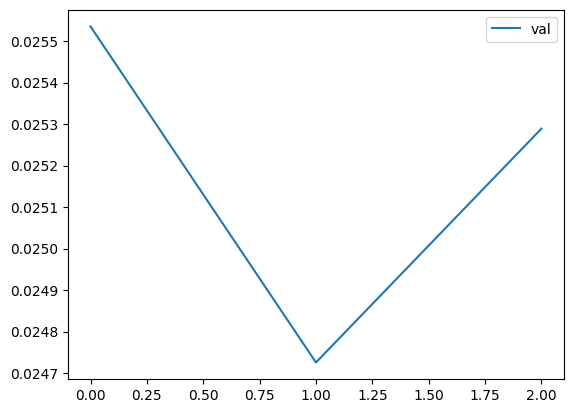

In [64]:
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
# plt.plot(to_cpu(losses), label="train")
plt.plot(to_cpu(val_losses)[0:], label="val")
plt.legend()

In [65]:
#ae.load_state_dict(torch.load(f'autoencoders/ckpts/autoencoder_{feature_size}_1l.pt'))

FileNotFoundError: [Errno 2] No such file or directory: 'autoencoders/ckpts/autoencoder_128_1l.pt'

### Reconstruction on Validation data

In [66]:
from torchvision.utils import save_image, make_grid

def plot_grid(generated_grid):
    plt.figure(figsize=(10,10))
    plt.imshow(generated_grid.permute(1,2,0).detach().to(cpu_device).numpy())

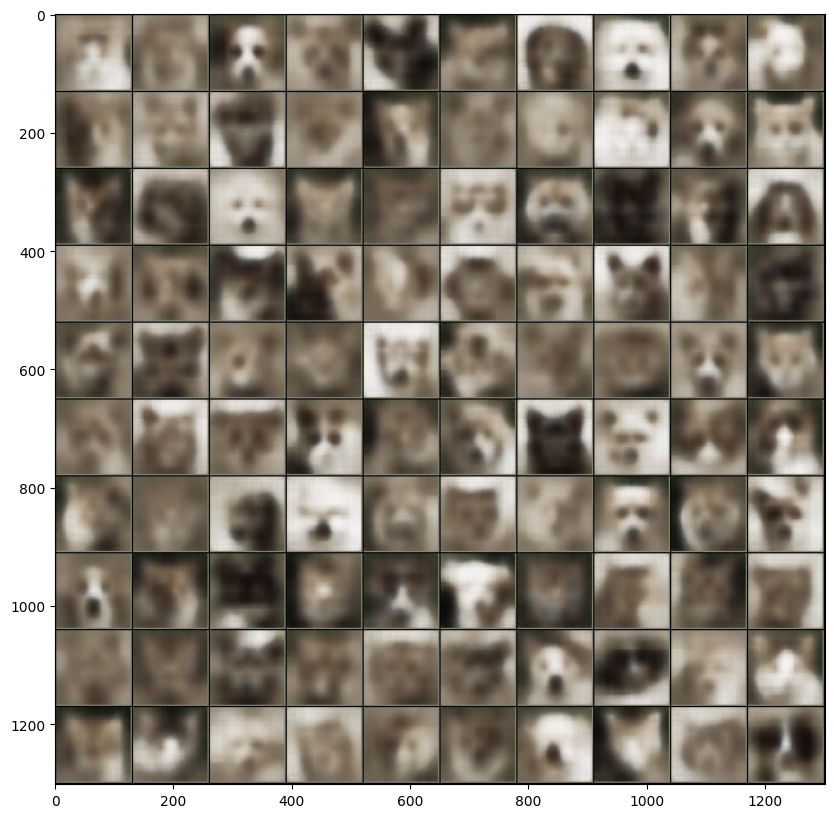

In [67]:
x, y = next(iter(val_loader))
x_hat, enc = ae(x.to(device))
generated_grid = make_grid(x_hat[:100], nrow=10)
# save_image(generated_grid,f"generated_{feature_size}_1l.png")
plot_grid(generated_grid)

In [68]:
x.shape

torch.Size([512, 3, 128, 128])

In [69]:
x_hat, enc = ae(x.to(device))

### Classificaton on latents by AE

In [70]:
def get_latents(ae, dataloader, device=torch.device("cuda")):
    temp, labels = [], []
    for X,y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            ae.eval()
            enc = ae.encoder(X)
            temp.append(enc)
            labels.extend(y)
    latents = torch.cat(temp).to(device)
    return latents, torch.tensor(labels)

In [71]:
class Classifier(nn.Module):
    def __init__(self, ip_dim):
        super(Classifier, self).__init__()
        hidden_layers = []
        self.fc1 = nn.Linear(ip_dim, 256)
        self.fc2 = nn.Linear(256, 3)
        
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [72]:
train_ae_latents, train_ae_labels = get_latents(ae, train_loader)
val_ae_latents, val_ae_labels = get_latents(ae, val_loader)
print(train_ae_latents.shape, val_ae_latents.shape)

100%|██████████| 3/3 [00:16<00:00,  5.60s/it]

torch.Size([14630, 128]) torch.Size([1500, 128])


In [73]:
import torch
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(train_ae_latents, train_ae_labels)
batch_size = 256 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [75]:
n_epochs = 5
tqdm_obj = tqdm(range(n_epochs))
train_losses = []
val_losses = []

cl = Classifier(ip_dim=feature_size).to(device)
optim = torch.optim.Adam(cl.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

for epoch in tqdm_obj:
    for x,y in dataloader:
        x,y = x.to(device), y.to(device)
        # train
        cl.train()
        optim.zero_grad()
        logits = cl(x)
        loss = loss_fn(logits, y.type(torch.LongTensor).to(device))
        loss.backward()
        optim.step()
        train_losses.append(loss)
    
    # val
    cl.eval()
    with torch.no_grad():
        val_logits = cl(val_ae_latents)
        val_loss = loss_fn(val_logits, val_ae_labels.type(torch.LongTensor).to(device))
        val_losses.append(val_loss)
    
    tqdm_obj.set_description_str(f"Epoch: {epoch} Train loss: {loss} Val loss: {val_loss}")
    

Epoch: 4 Train loss: 0.5021421313285828 Val loss: 0.5213431119918823: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


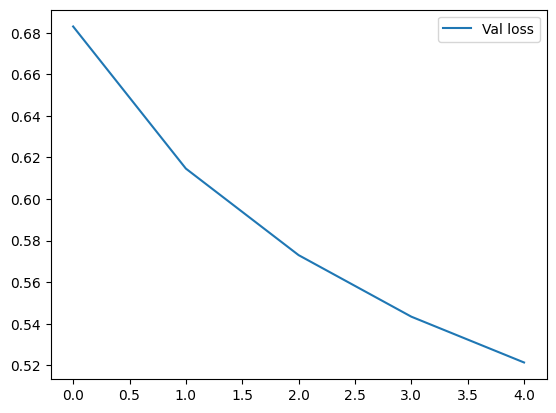

In [76]:
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
plt.plot(to_cpu(val_losses), label="Val loss");
plt.legend()

In [77]:
val_y_pred = torch.argmax(val_logits, dim=-1)
val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=3)(val_y_pred.to(cpu_device), val_ae_labels)
print(f"Validation accuracty on latents by AE: {val_acc}")

Validation accuracty on latents by AE: 0.7926666736602783


### Trying different latent sizes

In [78]:
train_latents, train_labels = get_latents(ae, train_loader)
val_latents, val_labels = get_latents(ae, val_loader)

100%|██████████| 3/3 [00:17<00:00,  5.88s/it]


100%|██████████| 40/40 [00:59<00:00,  1.48s/it]


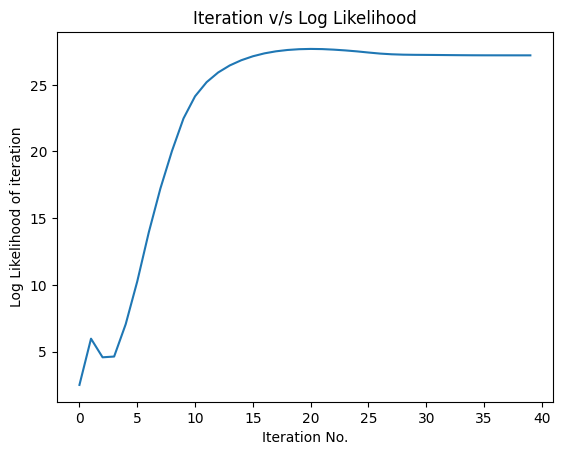

torch.Size([100, 128])

In [82]:
gmm = GaussianMixture(n_components=4, n_iters = 40, eps = 1e-5)
gmm.fit(train_latents.to(cpu_device))
gmm._plot_likelihood_curve()
latent_output = gmm._generate_samples(100)
latent_output.shape

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

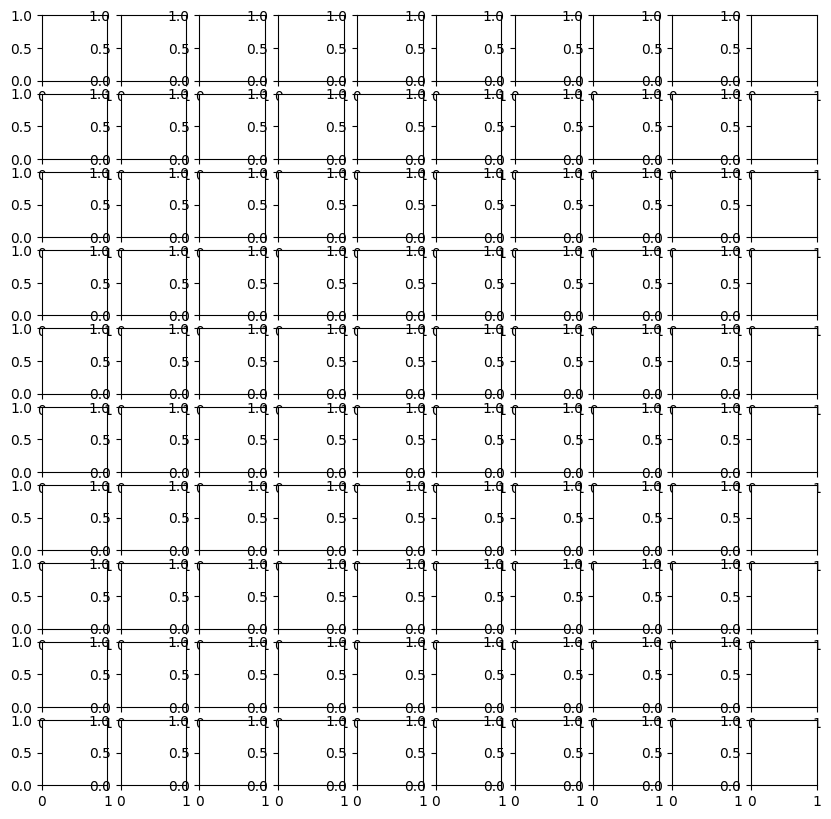

In [88]:
reconstructed = ae.decoder(latent_output.to(device))
grid_size = (10, 10)
_, axarr = plt.subplots(*grid_size, figsize=(10, 10))
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        sample = reconstructed[i * grid_size[1] + j].view(3, 128, 128).permute(1,2,0).detach().numpy()
        sample = np.clip(sample, 0, 1)
        axarr[i, j].imshow(sample)
        axarr[i, j].axis('off') #remove x, y axis from images
plt.suptitle(f"Samples generated from Latent Variable Input")
plt.show()